# Workshop 5. Рекомендательная система

1. Скачайте этот ноутбук к себе.
2. Заполните пропущенные ячейки, отвечая на заданные вопросы. Там должен быть код! (если не сказано обратное)
3. Сохраните результат в своём гитхаб репозитории.

### Полезная литература

- [Лекция 8. Рекомендательный системы](https://www.youtube.com/watch?v=Te_6TqEhyTI&t=4s).
- [Туториал по рекомендательным системам](http://nbviewer.jupyter.org/urls/gitlab.7bits.it/isiganov/ml-course/raw/master/week05/theory/05-01-clustering.ipynb?inline=false)

- [ODS: Обучение без учителя: PCA и кластеризация](https://habrahabr.ru/company/ods/blog/325654/)
- [Интересные алгоритмы кластеризации, часть первая: Affinity propagation](https://habrahabr.ru/post/321216/) и другие статьи цикла
- [Глава 7: кластеризация и визуализация. К. В. Воронцов](http://www.machinelearning.ru/wiki/images/6/6d/Voron-ML-1.pdf)
- [Документация sklearn.clustering](http://scikit-learn.org/stable/modules/clustering.html)
- [K-Means Clustering - The Math of Intelligence. Siraj Raval](https://www.youtube.com/watch?v=9991JlKnFmk) объяснение с программированием KMeans вручную

В этой практике мы попробуем построить очень простую рекомендательную систему, основанную на поиске кластера похожих пользователей.  
Похожие они в том плане, что смотрят одинаковые фильмы и оценивают их приблизительно одинаково.  
Мы будем строить очень простую модель, по сути которая даже не является именно системой рекомендации, но как минимум она может быть первым шагом к ее построению: мы найдем класет похожих пользователей, узнаем какие фильмы они смотрят и одинаково любят, какие жанры предпочитают.

Лабораторная будет больше похожа на манипулции с одним большим датафреймом. Если у вас появятся интересные идеи, то можете попробовать их тоже. 

## Анализ отзывов аниме

Возьмем датасет с рейтингами аниме: https://www.kaggle.com/CooperUnion/anime-recommendations-database  
Кстати, вы можете посмотреть kernels - это jupyter notebooks, в которых другие люди тоже делали что-то с этим датасетом.

```
Anime.csv

anime_id - myanimelist.net's unique id identifying an anime.
name - full name of anime.
genre - comma separated list of genres for this anime.
type - movie, TV, OVA, etc.
episodes - how many episodes in this show. (1 if movie).
rating - average rating out of 10 for this anime.
members - number of community members that are in this anime's "group".


Rating.csv

user_id - non identifiable randomly generated user id.
anime_id - the anime that this user has rated.
rating - rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating).
```

In [2]:
import pandas as pd

In [3]:
anime = pd.read_csv('anime/anime.csv.zip', index_col='anime_id')
anime.dropna(inplace=True)
print(anime.shape)
anime.head()

(12017, 6)


,name,genre,type,episodes,rating,members
anime_id,,,,,,
32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [4]:
ratings = pd.read_csv('anime/rating.csv.zip')
ratings.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


## Обзор данных

Постройте графики для обзора признаков: anime.type, episodes, rating, members.

Посмотрите на info по таблицам, нам важно знать сколько оперативной памяти занимает каждая таблица, так как дальше у нас будет декартово произведение таблиц и размер может вылететь за 5 гигабайт.

In [5]:
anime.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 12017 entries, 32281 to 26081
Data columns (total 6 columns):
name        12017 non-null object
genre       12017 non-null object
type        12017 non-null object
episodes    12017 non-null object
rating      12017 non-null float64
members     12017 non-null int64
dtypes: float64(1), int64(1), object(4)
memory usage: 657.2+ KB


In [6]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
user_id     int64
anime_id    int64
rating      int64
dtypes: int64(3)
memory usage: 178.8 MB


In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#sns.pairplot(data=anime["type,episodes,rating,members".split(',')], size=5)

## Жанры

Как в материалах к воркшопу постройте таблицу, в которой в строках будет названиефильма, а в столбцах жанр. В ячейках 1 - если в этого фильма есть такой жанр и 0 иначе.

Постройте countplot для визуализации количества фильмов каждого из жанров.

Постройте график, на котором будут изображениы распределения рейтингов по каждому из жанров. Должно получиться что-то подобное: ![Imgur](https://i.imgur.com/hyuA6ia.png)

In [8]:
movie_anime = anime[anime["type"] == "Movie"]



from itertools import chain
'''
Нам нужна функция flatmap.
Flatmap получает на вход список, на каждом элементе вызывает функцию f, которая возвращает другой список.
В результате получается список списков. В конфе происходит flatten - уплощение списка скписков в один список.
'''
def flatmap(f, items):
    return chain.from_iterable(map(f, items))

def genre_splitter(genre_names):
    return genre_names.split(", ")

m_uniq = movie_anime['genre'].unique() # смотрим сколько всего уникальных комбинация genres есть в датасете

genres = set(flatmap(genre_splitter, m_uniq)) # разбиваем все genres на составные части и генерируем один массив из всех жанров. Строим по массиву множество уникальных жанров

genres = list(genres) # множество превращаем в список
print("Genres={}\nlen={}".format(genres, len(genres)))



Genres=['Shounen Ai', 'Dementia', 'Seinen', 'Mecha', 'Demons', 'Romance', 'Kids', 'Horror', 'Cars', 'Slice of Life', 'Military', 'Supernatural', 'Drama', 'Josei', 'Adventure', 'Sci-Fi', 'Thriller', 'Samurai', 'Space', 'Police', 'Parody', 'School', 'Fantasy', 'Martial Arts', 'Shoujo', 'Vampire', 'Ecchi', 'Super Power', 'Sports', 'Mystery', 'Psychological', 'Historical', 'Shounen', 'Game', 'Harem', 'Hentai', 'Action', 'Magic', 'Music', 'Comedy']
len=40


In [9]:
pd_movie_anime = pd.DataFrame(index=movie_anime.index)

for g in genres:
    pd_movie_anime[g] = movie_anime['genre'].str.contains(g).astype(int)


In [10]:

pd_movie_anime.head(30)

pd_movie_anime.set_index(movie_anime["name"])

,Shounen Ai,Dementia,Seinen,Mecha,Demons,Romance,Kids,Horror,Cars,Slice of Life,...,Psychological,Historical,Shounen,Game,Harem,Hentai,Action,Magic,Music,Comedy
name,,,,,,,,,,,,,,,,,,,,,
Kimi no Na wa.,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Gintama Movie: Kanketsu-hen - Yorozuya yo Eien Nare,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,1,0,0,1
Koe no Katachi,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
Sen to Chihiro no Kamikakushi,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Ookami Kodomo no Ame to Yuki,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
Mononoke Hime,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
Suzumiya Haruhi no Shoushitsu,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
Mushishi Zoku Shou: Suzu no Shizuku,0,0,1,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
Howl no Ugoku Shiro,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
pd_movie_anime.sum()

Shounen Ai         5
Dementia         172
Seinen            56
Mecha            163
Demons            43
Romance          165
Kids             444
Horror            66
Cars              12
Slice of Life    166
Military         105
Supernatural     155
Drama            473
Josei              2
Adventure        634
Sci-Fi           397
Thriller          25
Samurai           29
Space             94
Police            49
Parody            31
School           100
Fantasy          570
Martial Arts      48
Shoujo            85
Vampire            8
Ecchi             30
Super Power       92
Sports           115
Mystery           86
Psychological     67
Historical       225
Shounen          372
Game              14
Harem              7
Hentai             8
Action           546
Magic            108
Music             85
Comedy           678
dtype: int64

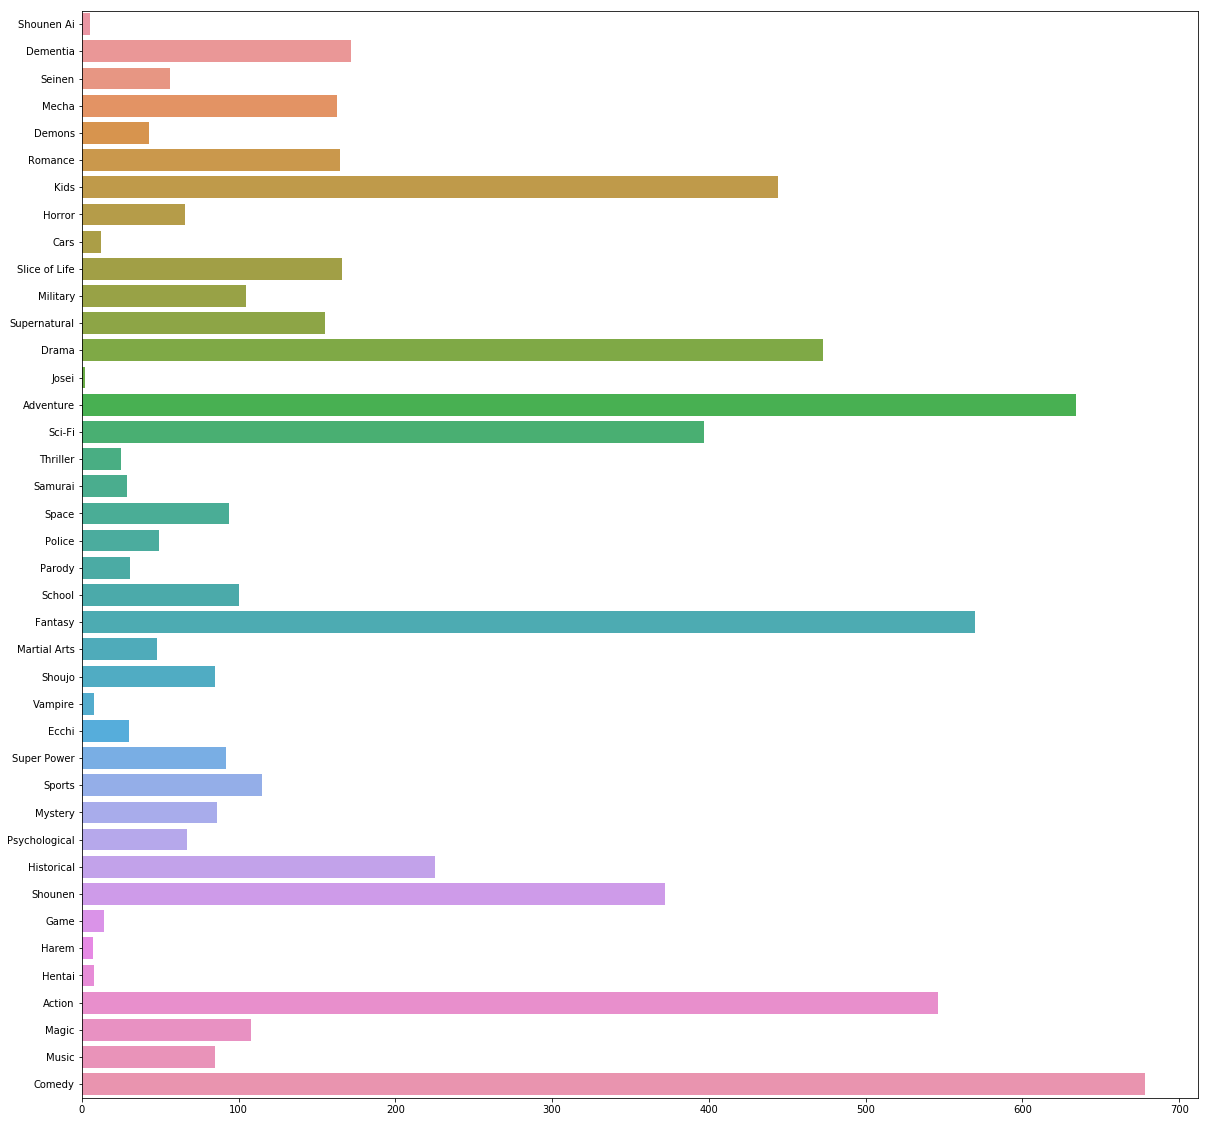

In [12]:

plt.figure(figsize=(20,20))
sns.barplot(x=pd_movie_anime.sum(),y=genres)

D:\Program Files\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


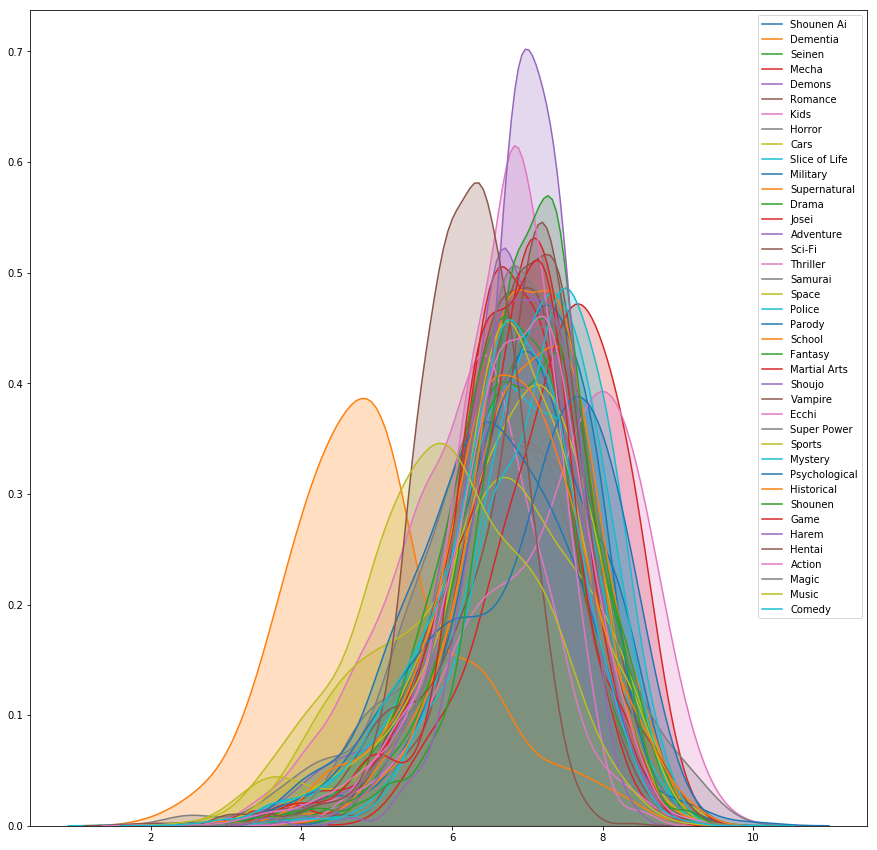

In [13]:

fig, ax = plt.subplots(figsize=(15,15))
for g in genres:
    sns.kdeplot(anime[anime['genre'].str.contains(g)]['rating'], shade=True, label=g, ax=ax)
    

## Рейтинг

Постройте график, показывающий сколько оценок каждого рейтинга поставили пользователи из таблицы `ratings`.

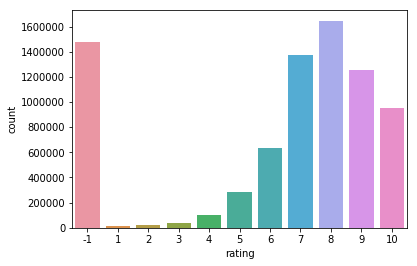

In [14]:
sns.countplot(x="rating", data=ratings)

## Фильтрация данных

Если мы сразу же построим кросстаб матрицу `anime` vs `user`, где в ячейках рейтинг, который поставил юзер этому фильму, то у нас это все займет около 6 гигабайт памяти. Можно значительно сократить размер матрицы, если выкинуть данные об аниме, которое почти никто не оценил и юзеров, которые почти ничего не оценивали.

Для этого постройте два новых датафрейма:

- anime_watches, где индексом является anime_name, а значением - количество его обзоров
- user_ratings, где индексом является user_id, а значением - количество вниме, которое он оценил.

Далее, соедините (join) 4 таблицы: ratings, anime, anime_watches, user_ratings и назовите новую таблицу anime_ratings.

Что означает `-1` в таблице рейтинга? Замените все -1 на средний рейтинг аниме.

Удалите из таблицы все те значения, у которых количество обзоров и рейтингов меньше медианного значения. То есть мы удалим половину аниме и половину юзеров.

In [15]:


anime_watches = pd.DataFrame(index=ratings['anime_id'],data=ratings['anime_id'].value_counts())

user_rating = pd.DataFrame(index=ratings['user_id'].unique(),data=ratings['user_id'].value_counts())

anime_watches = anime_watches.rename(columns={"anime_id": "count_review"})

user_rating = user_rating.rename(columns={"user_id": "count_rating"})

#print(anime_watches)

#print(user_rating)

anime_watches


,count_review
anime_id,
20,25925
24,7153
79,7112
226,27506
241,4180
355,11950
356,14915
442,7846
487,3210


In [16]:
mean_rating = user_rating['count_rating'].median()
print(mean_rating)
user_rating[user_rating['count_rating'] < mean_rating]

57.0


,count_rating
2,3
4,52
6,37
8,12
9,1
10,8
12,22
15,2
16,11
18,25


In [17]:

user_rating = user_rating.drop(user_rating[user_rating['count_rating'] < mean_rating].index)

In [18]:
user_rating

,count_rating
1,153
3,94
5,467
7,343
11,112
13,174
14,123
17,601
21,180
23,72


In [19]:
mean_reviews = anime_watches['count_review'].median()
anime_watches.info()
#%time anime_watches[anime_watches['count_review'] >= mean_reviews]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7813737 entries, 20 to 8074
Data columns (total 1 columns):
count_review    int64
dtypes: int64(1)
memory usage: 119.2 MB


In [20]:
anime_watches.drop_duplicates()
anime_watches.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7813737 entries, 20 to 8074
Data columns (total 1 columns):
count_review    int64
dtypes: int64(1)
memory usage: 119.2 MB


In [22]:
anime_ratings = ratings \
    .join(anime, on="anime_id", lsuffix="_a", how='inner') \
    .join(user_rating[user_rating['count_rating'] >= mean_rating], on="user_id", how='inner') \
    .join(anime_watches[anime_watches['count_review'] >= mean_reviews], on="anime_id", how='inner') \
    
anime_ratings
# Все равно Memory Error на 16гб

MemoryError: 

## Матрица user-item

Превратите таблицу anime_ratings в матрицу, где в строках user_id, в стобцах anime_name, а в ячейках рейтинг. Посмотрите сколько занимет в памяти эта матрица.

In [23]:
mean_rating = user_rating['count_rating'].median()
print(mean_rating)

bad_user_rating = user_rating.drop(user_rating[user_rating['count_rating'] >= mean_rating].index)

136.0


In [24]:
mean_reviews = anime_watches['count_review'].median()
print(mean_reviews)

bad_anime_watches = anime_watches[anime_watches['count_review'] < mean_reviews]

4368.0


In [25]:
pd_anime_ratings = ratings.pivot_table(values='rating', index='user_id', columns='anime_id')
pd_anime_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73515 entries, 1 to 73516
Columns: 11200 entries, 1 to 34519
dtypes: float64(11200)
memory usage: 6.1 GB


In [26]:
pd_anime_ratings = pd_anime_ratings.fillna(0)

In [27]:
# Закоменчены строки для удаления по медиане
#pd_anime_ratings.drop(bad_user_rating.index, inplace=True)

In [28]:
#pd_anime_ratings.info()

In [29]:
#pd_anime_ratings.drop(bad_anime_watches.index, axis=1 ,inplace=True)

In [30]:
#pd_anime_ratings.info()

In [31]:
for i in pd_anime_ratings.columns:
    try: #В ratings есть anime_id которых нет в anime !?! При этом они какие-то не популярные ,так как если выбросить bad_anime_watches
        value = anime.loc[i]['rating']
        pd_anime_ratings[i] = pd_anime_ratings[i].replace(-1, value)
    except KeyError:
        pd_anime_ratings.drop(i, axis=1 ,inplace=True)

In [32]:
pd_anime_ratings

anime_id,1,5,6,7,8,15,16,17,18,19,...,34283,34324,34325,34349,34358,34367,34412,34475,34476,34519
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.00,0.0,8.32,0.0,0.0,0.0,0.00,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.00,0.0,8.00,0.0,0.0,6.0,0.00,6.0,6.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
anime_ratings = pd_anime_ratings.values

In [34]:
anime_ratings

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [10., 10., 10., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

## Понижение размерности

kNN будет плохо работать на многомерных данных, поэтому надо понизить размерности матрицы с помощью алгоритма PCA. Количество размерностей установите от 4 до 10 - как вам покажется оптимальнее. (можете это исправить когда запустите kNN и получите результаты).

In [35]:
from sklearn import decomposition

pca = decomposition.PCA(n_components=10)
df_pca = pca.fit_transform(anime_ratings)

## Обучение kNN

Обучим kNN, чтобы он нашел нам центры кластеров нашей выборки.

Так как в строках у нас user_id, то центры класетров - это будут характеристики пользователей в терминах их оценок аниме. Используя эту информацию мы можем вычислить список характерных аниме для конкретного кластера.

- обучите kNN
- создайте копию матрицы и добавьте новую колонку - кластер. Положите в нее результат предсказания кластера для каждого пользователя. (метод predict)
- нарисуйте cout plot количества юзеров в каждом кластере. Если получается сильно неравномерное распределение, то вам надо подобрать другое количество кластеров или изменить размерность в предыдущем шаге.

In [36]:
from sklearn.cluster import KMeans

n = 30

kMeans = KMeans(n_clusters=n)
kMeans.fit(df_pca)
pd_anime_ratings['Cluster'] = kMeans.predict(df_pca)

## Top 15 аниме

Найдем Top-15 аниме для каждого кластера. Для этого:

- найдите средний рейтинг аниме в каждом кластере. 
- для каждого кластера возьмите набор аниме с их средним рейтингом, отсортируйте этот набор по убыванию рейтинга. 
- возьмите первые 15 элементов из набора - это и будет топ15 аниме в кластере.
- согласны ли вы с содержимым кластера?

In [37]:
pd_anime_ratings

anime_id,1,5,6,7,8,15,16,17,18,19,...,34324,34325,34349,34358,34367,34412,34475,34476,34519,Cluster
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29
2,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12
4,0.00,0.0,8.32,0.0,0.0,0.0,0.00,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15
5,0.00,0.0,8.00,0.0,0.0,6.0,0.00,6.0,6.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18
6,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15
7,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
8,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
9,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [38]:
m = pd_anime_ratings.groupby('Cluster').mean()

In [39]:
for i in range(n):
    print(i)
    print(anime.loc[m.loc[i].sort_values(ascending=False)[:15].index]["name"])

0
anime_id
16498               Shingeki no Kyojin
853             Ouran Koukou Host Club
1535                        Death Note
9919                    Ao no Exorcist
4898                      Kuroshitsuji
7054             Kaichou wa Maid-sama!
20507                         Noragami
22319                      Tokyo Ghoul
11757                 Sword Art Online
18507                            Free!
14227           Tonari no Kaibutsu-kun
6746                        Durarara!!
11771                 Kuroko no Basket
199      Sen to Chihiro no Kamikakushi
14713           Kamisama Hajimemashita
Name: name, dtype: object
1
anime_id
1535                           Death Note
20                                 Naruto
853                Ouran Koukou Host Club
121                   Fullmetal Alchemist
226                            Elfen Lied
11757                    Sword Art Online
16498                  Shingeki no Kyojin
199         Sen to Chihiro no Kamikakushi
5114     Fullmetal Alchemist: B

## Top 5 жанров

Если соеднить таблицу с аниме с таблицей жанров, то можно найти топ жанров для каждого кластера. Придумайте сами как это сделать, так как тут много способов:

- найти средний рейтинг для аниме каждого жанра
- посчитать сколько представителей каждого жанра есть среди top100 аниме кластера (кстати работает лучше)
- ???

In [40]:
from collections import Counter


for i in range(n):
    print(i)
    a = list(flatmap(genre_splitter, anime.loc[m.loc[i].sort_values(ascending=False)[:100].index]["genre"].values))
    print(Counter(a).most_common(7))
        

0
[('Comedy', 45), ('Romance', 41), ('Action', 37), ('Supernatural', 36), ('Drama', 34), ('Fantasy', 28), ('School', 28)]
1
[('Comedy', 57), ('Action', 52), ('Supernatural', 33), ('Romance', 32), ('Drama', 32), ('Adventure', 29), ('Fantasy', 29)]
2
[('Action', 44), ('Supernatural', 39), ('Comedy', 39), ('Romance', 32), ('Mystery', 30), ('Drama', 28), ('Sci-Fi', 24)]
3
[('Comedy', 50), ('Action', 41), ('School', 41), ('Romance', 41), ('Supernatural', 38), ('Drama', 26), ('Fantasy', 24)]
4
[('Action', 54), ('Sci-Fi', 43), ('Drama', 40), ('Comedy', 34), ('Adventure', 32), ('Fantasy', 26), ('Romance', 24)]
5
[('Comedy', 59), ('Romance', 57), ('Action', 50), ('School', 48), ('Harem', 39), ('Supernatural', 37), ('Ecchi', 36)]
6
[('Action', 60), ('Supernatural', 38), ('Comedy', 36), ('Shounen', 33), ('Drama', 29), ('Fantasy', 29), ('Romance', 26)]
7
[('Adventure', 72), ('Action', 68), ('Comedy', 67), ('Fantasy', 64), ('Shounen', 64), ('Super Power', 27), ('Drama', 27)]
8
[('Comedy', 56), ('Ro